In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math
from tqdm import tqdm_notebook as tqdm

In [2]:
horse_df = pd.read_csv("dataSetHorseshoes.csv", names=['class','feature1','feature2'])
key = np.arange(1,11)
key = np.repeat(key,40)
np.random.shuffle(key)
horse_df['fold'] = key

In [3]:
def trainKNN(df, k):
    X = df[['feature1','feature2']]
    y = df['class']
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)
    return clf, df, k

In [4]:
def runDLRT(train_df, test, k):
    data0 = train_df[train_df['class']==0][['feature1','feature2']]
    data1 = train_df[train_df['class']==1][['feature1','feature2']]
    n0 = len(data0)
    n1 = len(data1)
    distance = lambda a, b: math.sqrt((a[0]-b[0]) ** 2 + (a[1]-b[1]) ** 2)
    distance0 = np.array([distance(test,train) for i,train in data0.iterrows()])
    distance1 = np.array([distance(test,train) for i,train in data1.iterrows()])
    distance0 = np.sort(distance0)
    distance1 = np.sort(distance1)
    distance0_k = distance0[k-1]
    distance1_k = distance1[k-1]
    g = np.log(n0 / n1) + 2 * (np.log(distance0_k) - np.log(distance1_k))
    if g>= 0:
        predict = 1
    else:
        predict = 0
    return g, predict

In [5]:
scores_ave = np.zeros(400)
class_ave = np.zeros(400)
for j in range(1,11):   #specify fold
    train_df = horse_df[horse_df['fold']!=j]
    X_test = horse_df[horse_df['fold']==j][['feature1','feature2']]
    y_test = horse_df[horse_df['fold']==j]['class']
    Z = np.array([runDLRT(train_df,test,3) for i,test in tqdm(X_test.iterrows(),total=len(X_test),leave=False)])
    Z = Z[:,0]
    scores_ave[(j-1)*40:j*40] = Z
    class_ave[(j-1)*40:j*40] = y_test
    
fpr1, tpr1, thresholds1 = metrics.roc_curve(class_ave, scores_ave)

Text(0.5, 1.0, 'Receiver Operating Characteristic')

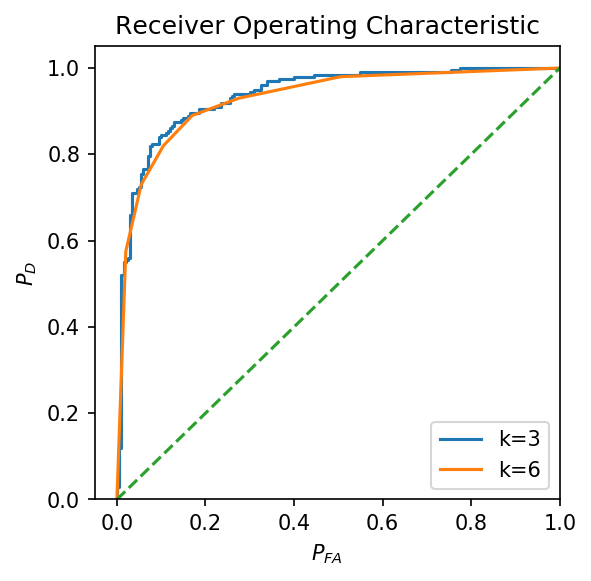

In [6]:
scores_ave = np.zeros(400)
class_ave = np.zeros(400)
for j in range(1,11):   #specify fold
    X_train = horse_df[horse_df['fold']!=j][['feature1','feature2']]
    y_train = horse_df[horse_df['fold']!=j]['class']
    X_test = horse_df[horse_df['fold']==j][['feature1','feature2']]
    y_test = horse_df[horse_df['fold']==j]['class']
    clf = KNeighborsClassifier(n_neighbors=6)
    clf.fit(X_train,y_train)
    scores_ave[(j-1)*40:j*40] = clf.predict_proba(X_test)[:,1]
    class_ave[(j-1)*40:j*40] = y_test
    
fpr, tpr, thresholds = metrics.roc_curve(class_ave, scores_ave)
plt.figure(figsize=(4,4),dpi=150)
plt.plot(fpr1, tpr1,label='k=3')
plt.plot(fpr, tpr,label='k=6')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()
plt.xlabel('$P_{FA}$')
plt.ylabel('$P_D$')
plt.title('Receiver Operating Characteristic')